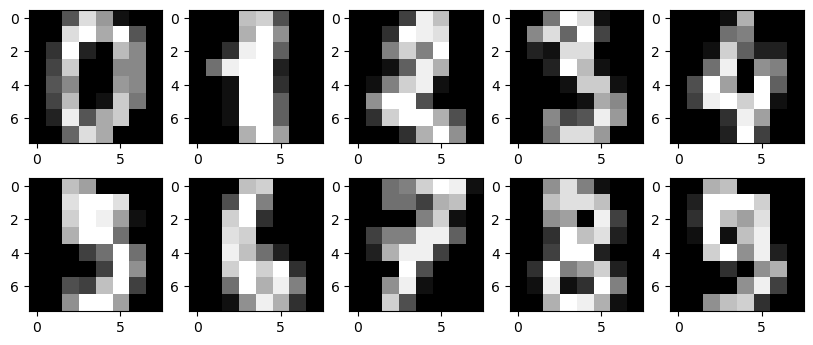

In [55]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()
X, y = digits.data, digits.target

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for lbl in np.unique(y):
    axs[lbl // 5, lbl % 5].imshow(X[y == lbl][0].reshape(8,8), cmap = 'gray')

### Stochastic Neighborhood Embedding (SNE)

We focus on point $\mathbf{x}_i$. Then we build a Gaussian distribution of distances from $\mathbf{x}_i$ with standard deviation $\sigma_i$:

$$
g(\mathbf{x}_i, \mathbf{x}) = \text{Exp}\left(\frac{-\|\mathbf{x}_i - \mathbf{x}\|_2^2}{2\sigma_i^2}  \right).
$$

Then we can compute the conditional probability that $\mathbf{x}_i$ will pick $\mathbf{x}_j$ as its neighbor as:

$$
p_{i | j} = \frac{g(\mathbf{x}_i, \mathbf{x}_j)}{\sum_{r \neq i} g(\mathbf{x}_i,\mathbf{x}_r)}.
$$

Notice that these conditional probabilities are not symmetric because $\sigma_i \neq \sigma_j$.

We seek a low-dimensional embedding of the data (in the latent space) $\{\mathbf{z}_i\}_{i=1}^p \in \mathbb{R}^k$ with the distributions using standard deviation $\sigma = \frac{1}{\sqrt{2}}$:

$$
h(\mathbf{z}_i, \mathbf{z}) = \text{Exp}\left(-\|\mathbf{z}_i - \mathbf{z}\|_2^2\right).
$$

Along with the conditional distributions for neighbor picking:

$$
q_{i | j} = \frac{h(\mathbf{z}_i, \mathbf{z}_j)}{\sum_{r \neq i} h(\mathbf{z}_i,\mathbf{z}_r)}.
$$

Define $P_i$ and $Q_i$ as the conditional probability distributions over all data points given $\mathbf{x}_i$ and $\mathbf{z}_i$, respectively. SNE seeks the low-dimensional embedding that best matches the two probability distributions using KL-divergence. Specifically, the classical SNE cost function is:

$$
C = \sum_{i=1}^n \text{KL}(P_i || Q_i) = \sum_{i=1}^n \sum_{j=1}^n p_{j|i} \log \left( \frac{p_{j|i}}{q_{j|i}} \right).
$$

SNE classically minimizes $C$ using gradient descent on the embedding vectors $\{\mathbf{z}_i\}_i$. Because this cost function is not symmetric, SNE prioritizes preserving local structures. 


The gradient of $C$ with respect to $\mathbf{z}_i$ is intuitively the force created by springs between $\mathbf{z}_i$ and all other points in the reduced space.

We compute $\sigma_i$ using *perplexity*:

$$
\text{Perp}(P_i) = 2^{H(P_i)} \quad \text{where} \quad H(P_i) = -\sum_{j=1}^p p_{j|i} \log_2 (p_{j|i}).
$$
* lower perplexity = fine detail (tight clusters)
* larger perplexity = broader context

We call $H(P_i)$ the Shannon entropy of $P_i$. Shannon entropy can be thought of as the average "surprise" inherent in a random variable’s outcomes. The Shannon entropy of $P_i$ increases as $\sigma_i$ increases. The user *fixes a perplexity* and then performs a binary search for the $\sigma_i$.
* small $\sigma_i$ = dense distribution
* large $\sigma_i$ = sparse distribution

SNE has three major problems: 
1. *Crowding problem*: Because Gaussian tails decay exponentially, moderate distances in high dimensions collapse into small neighborhoods in the low-dimensional space, which forces many points to crowd together unnaturally. 
2. Asymmetry of $g$ because $p(i|j) \neq p(j|i)$
3. KL divergence is difficult to optimize





### t-SNE (t-distributed SNE)
#### Crowding

t-SNE solves these two problems. t-SNE addresses the crowding problem by replacing the Gaussian in the latent space with a Student-t distribution. This distribution has heavy tails which give us space for placing the $\mathbf{z}_i$:

$$
h_t(\mathbf{y}_i, \mathbf{y}_j) = \left(1 + \|\mathbf{z}_i - \mathbf{z}_j \|_2^2\right)^{-1}
$$


<img src="./images/tsne_image.png" alt="isolated" width="300"/>

#### Symmetry of Probabilities

t-SNE symmetrizes the conditional probabilities by considering joint probability distributions. (Note: just doing SNE with joint probabilities is called "Symmetric SNE.") We define:

$$
p_{i, j} = \frac{p_{i| j} + p_{j|i}}{2n} \quad \text{and} \quad q_{i, j} = \frac{h_t(\mathbf{z}_i, \mathbf{z}_j)}{\sum_{r \neq l} h_t(\mathbf{z}_r,\mathbf{y}_l)}.
$$

Using this allows us to accurately model moderate distances in the latent space.

#### Optimization of KL Divergence

The gradient of SNE with respect to the latent point $\mathbf{z}_i$ is:

$$
2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(\mathbf{z}_i - \mathbf{z}_j)
$$

The gradient for t-SNE with respect to the latent point $\mathbf{z}_i$ is:

$$
4 \sum_j (p_{ij} - q_{ij})(\mathbf{z}_i - \mathbf{z}_j)(1+\|\mathbf{z}_i - \mathbf{z}_j\|_2^2)^{-1}
$$

t-SNE strongly pushes dissimilar data points away from one another if they're modeled by small pairwise distances in the latent space. Additionally, these strong repulsions do not go to infinity like they do in SNE.

#### Comments
**Strengths:** Solves Isomap short-circuiting problem similarities between two datapoints integrates over all paths through neighborhood graph

**Weaknesses:** 
* Unclear how well it preforms with $k>3$ dimensions
* Sense to curse of intrinsic data dimensionality  ecause it fits data locally
* Non-convex optimization function


#### Parameter Tuning

**Parameters**
* Perplexity
* Learning rate (for optimizer)
* Number of iterations (for optimizer)

A link to explore the effects for tuning t-SNE parameters:
https://distill.pub/2016/misread-tsne/


#### Reference
https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b8d01c5cc20>
Traceback (most recent call last):
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

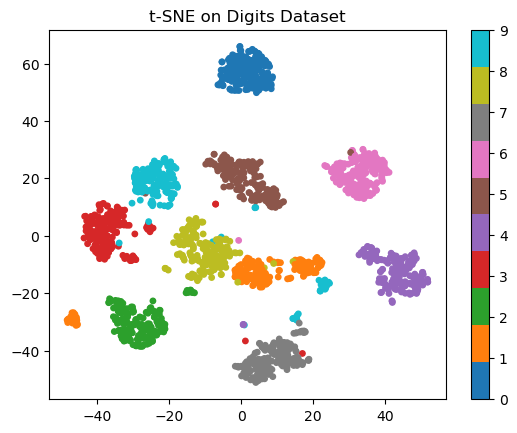

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
tsne_embedding = tsne.fit_transform(X)

plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=y, cmap='tab10', s=15)
plt.title("t-SNE on Digits Dataset")
plt.colorbar()
